#### Problem

Our aim is to generate colorful image from a grayscale image, which has only 1 value per pixel (lightness only). For simplicity, we will only work with images of size $256 \times 256$.

We'll try to predict the color values of the input image directly (using regression).

In [ ]:
!nvidia-smi

Wed Jun 16 09:27:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install and Import Libraries

In [ ]:
# Download and import libraries
!pip install torch torchvision matplotlib numpy scikit-image pillow==4.1.1

     |████████████████████████████████| 11.3MB 5.1MB/s 
     |████████████████████████████████| 112kB 41.6MB/s 
  Created wheel for pillow: filename=Pillow-4.1.1-cp37-cp37m-linux_x86_64.whl size=1009634 sha256=388a9e888abd7cf53d66eef32bec75b5e22e0c17344632a7b82972b3a64b0f8a
  Stored in directory: /root/.cache/pip/wheels/3f/f3/3e/f24b51fe136968f797933559011acd48b16708fc306c924770
  Created wheel for olefile: filename=olefile-0.46-py2.py3-none-any.whl size=35431 sha256=58c550e9d8124169c9e9ccd238a1dae9edd2b3f4a9fa2b358d7629448034ff1a
  Stored in directory: /root/.cache/pip/wheels/4b/f4/11/bc4166107c27f07fd7bba707ffcb439619197638a1ac986df3
Successfully built pillow olefile
ERROR: scikit-image 0.16.2 has requirement pillow>=4.3.0, but you'll have pillow 4.1.1 which is incompatible.
ERROR: bokeh 2.3.2 has requirement pillow>=7.1.0, but you'll have pillow 4.1.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incom

In [ ]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
from torchvision import datasets, transforms
import torchvision.models as models
# For utilities
import os, shutil, time


In [ ]:
# Check if GPU is available
use_gpu = torch.cuda.is_available()

###Import Dataset

For Colorization here we are using a subset of the [MIT Places](http://places.csail.mit.edu/) dataset of places, landscapes, and buildings.

In [ ]:
# Download and unzip (2.2GB)
!wget http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz
!tar -xzf testSetPlaces205_resize.tar.gz

--2021-06-16 09:28:32--  http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.129.40
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.129.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2341250899 (2.2G) [application/octet-stream]
Saving to: ‘testSetPlaces205_resize.tar.gz’

testSetPlaces205_re 100%[===================>]   2.18G  29.9MB/s    in 2m 5s   

2021-06-16 09:30:38 (17.8 MB/s) - ‘testSetPlaces205_resize.tar.gz’ saved [2341250899/2341250899]



In [ ]:
# Move data into training and validation directories
import os
os.makedirs('images/train/class/', exist_ok=True) # 3600 images
os.makedirs('images/val/class/', exist_ok=True)   #  400 images
os.makedirs('images/test/class/', exist_ok=True)   #  20 images
for i, file in enumerate(os.listdir('testSet_resize')):
  if i < 400:
    os.rename('testSet_resize/' + file, 'images/test/class/' + file)
  elif i >= 400 and i < 1400:
    os.rename('testSet_resize/' + file, 'images/val/class/' + file)
  else:
    os.rename('testSet_resize/' + file, 'images/train/class/' + file)

###Model
Our model is a convolutional neural network. We first apply a number of convolutional layers to extract features from our image. Specifically, the beginning of our model will be ResNet-18, an image classification network with 18 layers and residual connections. We will modify the first layer of the network so that it accepts grayscale input rather than colored input, and we will cut it off after the 6th set of layers. Finally at the end we apply deconvolutional layers to upscale (increase the spacial resolution) of our features.

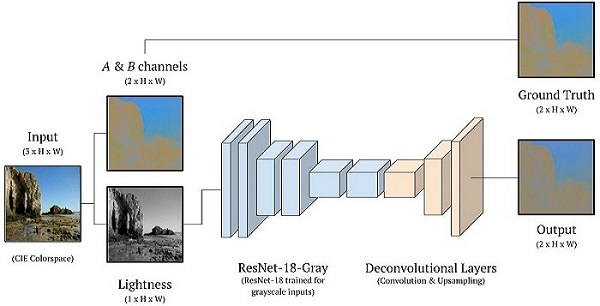




Now, we'll define our model in code. We'll start with the second half of the net, the upsampling layers:

In [ ]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365)
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
    # Extract midlevel features from ResNet-gray
    ##See here
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),

      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

Now let's create our model and load it onto the GPU.

In [ ]:
model = ColorizationNet()

### Useful Functions

#### Loss Function
We are using mean squared error as loss function.

In [ ]:
criterion = nn.MSELoss()

#### Optimizer

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)

#### Loading the data

We'll use torchtext to load the dat and alos define a custom dataloader to convert the images into grayscale.

In [ ]:
class GrayscaleImageFolder(datasets.ImageFolder):
  '''Custom images folder, which converts images to grayscale before loading'''
  def __getitem__(self, index):
    path, target = self.imgs[index]
    img = self.loader(path)
    if self.transform is not None:
      img_original = self.transform(img)
      img_original = np.asarray(img_original)
      img_lab = rgb2lab(img_original)
      img_lab = (img_lab + 128) / 255
      img_ab = img_lab[:, :, 1:3]
      img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
      img_original = rgb2gray(img_original)
      img_original = torch.from_numpy(img_original).unsqueeze(0).float()
    if self.target_transform is not None:
      target = self.target_transform(target)
    return img_original, img_ab, target

Here we define transforms for our training and validation data.

In [ ]:
# Training
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
train_imagefolder = GrayscaleImageFolder('images/train', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)

# Validation
val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
val_imagefolder = GrayscaleImageFolder('images/val' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

#### Helper functions

Before we train, we define helper functions for tracking the training loss and converting images back to RGB.

In [ ]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial'''
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None:
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

#### Validation

In validation, we simply run model without backpropagation using `torch.no_grad`.

In [ ]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation. \n')
  return losses.avg

#### Training

In training, run model and backpropagate using `loss.backward()`. We first define a function that trains for one epoch:

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):

    # Use GPU if available
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray)
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses))

  print('Finished training epoch {}'.format(epoch))

In [ ]:
# Move model and loss function to GPU
if use_gpu:
  criterion = criterion.cuda()
  model = model.cuda()

### Start Training

Next, we define a training loop and we train for 200 epochs:

In [ ]:
# Make folders and set parameters
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 50

In [ ]:
# Train model
for epoch in range(epochs):
  # Train for one epoch, then validate
  train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    losses = validate(val_loader, model, criterion, save_images, epoch)
  # Save checkpoint and replace old best model if current model is better
  if losses < best_losses:
    best_losses = losses
    torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))

Starting training epoch 0
Epoch: [0][0/619]	Time 1.360 (1.360)	Data 1.256 (1.256)	Loss 0.4000 (0.4000)	
Epoch: [0][25/619]	Time 1.236 (1.240)	Data 1.192 (1.194)	Loss 0.0099 (0.1529)	
Epoch: [0][50/619]	Time 1.226 (1.234)	Data 1.182 (1.189)	Loss 0.0039 (0.0810)	
Epoch: [0][75/619]	Time 1.232 (1.232)	Data 1.189 (1.187)	Loss 0.0039 (0.0557)	
Epoch: [0][100/619]	Time 1.253 (1.233)	Data 1.209 (1.189)	Loss 0.0096 (0.0430)	
Epoch: [0][125/619]	Time 1.243 (1.233)	Data 1.199 (1.188)	Loss 0.0031 (0.0354)	
Epoch: [0][150/619]	Time 1.240 (1.233)	Data 1.197 (1.188)	Loss 0.0033 (0.0303)	
Epoch: [0][175/619]	Time 1.234 (1.233)	Data 1.190 (1.189)	Loss 0.0028 (0.0265)	
Epoch: [0][200/619]	Time 1.237 (1.232)	Data 1.194 (1.188)	Loss 0.0038 (0.0236)	
Epoch: [0][225/619]	Time 1.226 (1.233)	Data 1.182 (1.189)	Loss 0.0038 (0.0214)	
Epoch: [0][250/619]	Time 1.233 (1.233)	Data 1.189 (1.189)	Loss 0.0041 (0.0196)	
Epoch: [0][275/619]	Time 1.232 (1.233)	Data 1.188 (1.189)	Loss 0.0029 (0.0181)	
Epoch: [0][300/619]

### Results

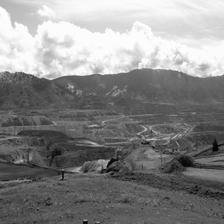

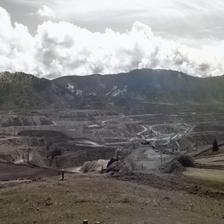

In [ ]:
# dislpaying an image
from IPython.display import Image, display
display(Image(filename='/content/outputs/gray/img-3-epoch-0.jpg'))
display(Image(filename='/content/outputs/color/img-3-epoch-179.jpg'))

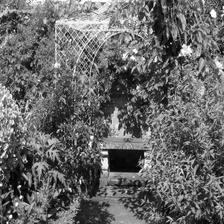

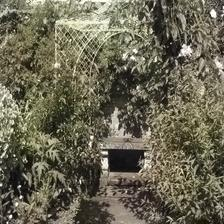

In [ ]:

display(Image(filename='/content/outputs/gray/img-4-epoch-0.jpg'))
display(Image(filename='/content/outputs/color/img-4-epoch-179.jpg'))

### Testing

In [ ]:
# Make folders and set parameters
os.makedirs('test/outputs/color', exist_ok=True)
os.makedirs('test/outputs/gray', exist_ok=True)
#os.makedirs('checkpoints', exist_ok=True)
save_images = True
#best_losses = 1e10
#epochs = 200

In [ ]:
# Test
test_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
test_imagefolder = GrayscaleImageFolder('images/test' , test_transforms)
test_loader = torch.utils.data.DataLoader(test_imagefolder, batch_size=64, shuffle=False)

In [ ]:
# Loading the best saved model
#model = ColorizationNet()
#model.load_state_dict(torch.load(PATH))
#model.cuda()

In [ ]:
def test(test_loader, model, criterion, save_images, epoch):
  model.eval()

  for i, (input_gray, input_ab, target) in enumerate(test_loader):
    # Use GPU
    if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(len(output_ab)):
        save_path = {'grayscale': 'test/outputs/gray/', 'colorized': 'test/outputs/color/'}
        save_name = 'img-{}-out.jpg'.format(i * test_loader.batch_size + j)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

  print('Finished Test. \n')

In [ ]:
# Test
save_images = True
with torch.no_grad():
  test(test_loader, model, criterion, save_images, 0)

In [ ]:
#!zip -r output.zip /content/outputs